# Predicting Pneumonia From Chest Radiology Images With Deep Learning

Author: **Marcin Sikorski**<br>
Date: January, 2023

**Introduction**<br>
Pneumonia is an infection that inflames the lungs air sacs (alveoli) and causes the lung tissue to swell. The air sacs usually fill up with fluid (pleural effusions) or pus, causing symptoms such as: trouble or shallow breathing, a cough, fever, and chills. Chest radiology imaging is the most frequently used method for diagnosing pneumonia. When interpreting the image, the radiologist will look for inflammations in the lungs: white spots (called infiltrates) that identify an infection, or for pleural effusions.

The subject of this repository is to perform binary classification based on patient's chest X-ray images. We will implement a deep learning technique which can categorize into these labels. We will develop a convolutional neural network with the <code>TensorFlow</code> library. The dataset (X-ray pictures) are available on the [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) website.

**Notebook Content**:<br>
1. Setting Up the Environment and Reading the Dataset<br>
2. Visualizing Folder Content<br>
3. Data Preprocessing and Augmentation<br>
4. CNN Architecture and Model Fitting<br>
5. Diagnosing Model Behavior (Model Uncertainty)<br>
6. Conclusion

### 1. Setting Up the Environment and Reading the Dataset

We will set the local paths (directories) to folders containing radiology images. The directories and their content should have the following structure:

<code>main_directory/</code><br>
<code>...class_a/<code>
<code>......a_image_1.jpg</code>
<code>......a_image_2.jpg</code>
<code>...class_b/</code>
<code>......b_image_1.jpg</code>
<code>......b_image_2.jpg</code>

In [1]:
import os

# set paths to data
# main folder
base_dir = os.getcwd()

# set train and test directory
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# set directories for pneumonia and normal images
# train data
train_pneum_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# test data
test_pneum_dir = os.path.join(test_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

# make separate files
train_pneum_names = os.listdir(train_pneum_dir)
train_normal_names = os.listdir(train_normal_dir)

test_pneum_names = os.listdir(test_pneum_dir)
test_normal_names = os.listdir(test_normal_dir)

### 2. Visualizing Folder Content

We will display 16 random items from <code>train</code> folders. First plots will show X-rays for patients with pneumonia. Next plots will display images for healthy patients.

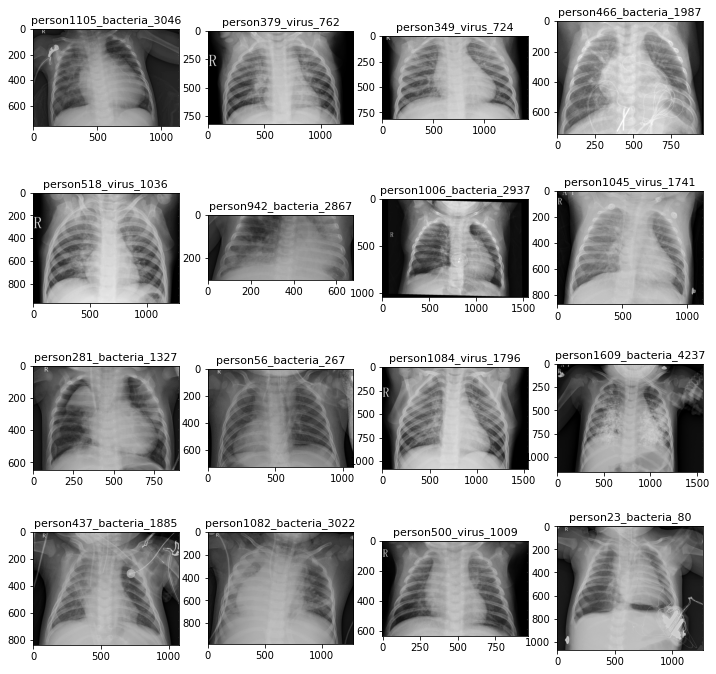

In [2]:
import matplotlib.pyplot as plt

# display pneumonia X-rays
def pneumonia_images():
    import random
    from matplotlib.image import imread
    
    plt.figure(figsize=(12, 12))
    
    # list of random images
    pneum_img = [os.path.join(train_pneum_dir, filename) for filename in random.sample(os.listdir(train_pneum_dir), 16)]
    
    for i, img_path in enumerate(pneum_img):
        plot = plt.subplot(4, 4, i+1)
        title = img_path.split('\\', 7)[7].split('.', 1)[0]
        img = imread(img_path)
        plot.set_title(title, fontsize=11)
        plot.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()
    
pneumonia_images()

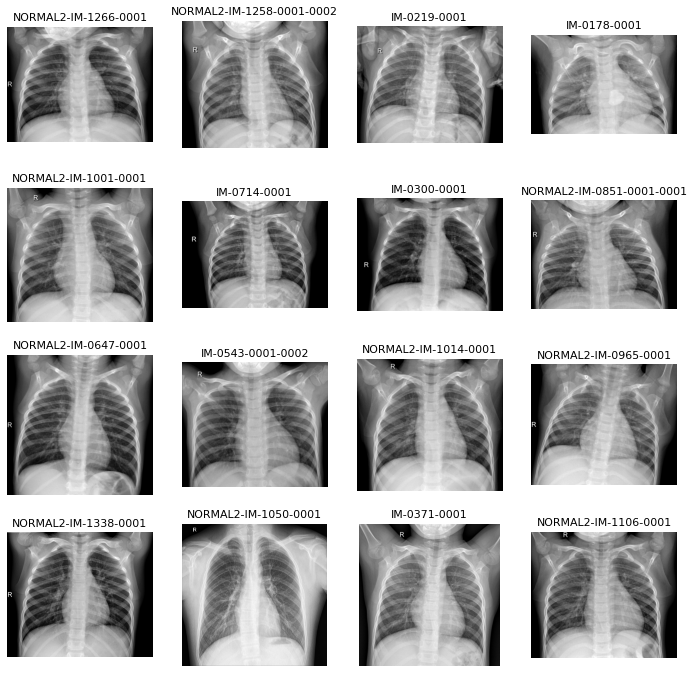

In [3]:
# display normal X-rays
def normal_images():
    import random
    from matplotlib.image import imread
    
    plt.figure(figsize=(12, 12))
    
    # list of random images
    normal_img = [os.path.join(train_normal_dir, filename) for filename in random.sample(os.listdir(train_normal_dir), 16)]
    
    for i, img_path in enumerate(normal_img):
        plot = plt.subplot(4, 4, i+1)
        title = img_path.split('\\', 7)[7].split('.', 1)[0]
        img = imread(img_path)
        plot.set_title(title, fontsize=11)
        plot.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()

normal_images()

It is easy to spot that healthy patients have clearer lung tissue, with no inflammations. Patients with pneumonia have shadowed chest images.

### 3. Data Preprocessing and Augmentation

At this step, we will generate batches of tensor image data with real-time data augmentation. The pictures will be resized and shuffled. To improve the validation process, we will flip the images horizontally and add a rescaling factor. It also helps the model to generalize on different types of images. Data augmentation also prevents overfitting.

In [4]:
# generate batches of tensor image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
# data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255 )
    
# apply image augmentation
train_data = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), subset='training',
                                               batch_size=32, class_mode='binary', shuffle=True)

validation_data = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), subset='validation',
                                                    batch_size=32, class_mode='binary', shuffle=True)

test_data = test_datagen.flow_from_directory(directory=test_dir, target_size=(150, 150), batch_size=32,
                                             class_mode='binary', shuffle=True)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# display labels
print('Class Labels: {}'.format(train_data.class_indices))

# display dimensions of target images - (width, height, color channels)
print('Shape of Images: {}'.format(train_data.image_shape))

Class Labels: {'NORMAL': 0, 'PNEUMONIA': 1}
Shape of Images: (150, 150, 3)


### 4. CNN Architecture and Model Fitting

In deep learning, a convolutional neural network (CNN, or ConvNet) is a type of artificial neural network, mostly applied to analyze visual imagery. It is used on image or audio data, or whenever we want to find patterns in data. A neural network is a supervised machine learning algorithm. A conventional CNN model is composed of convolutional layers (for extracting features from the input images), pooling layers (for reducing the dimensionality of each feature map retaining the most significant information), and flattening layers (for converting into a linear array). The following picture shows a standard architecture for CNN models for a multiclass classfier.

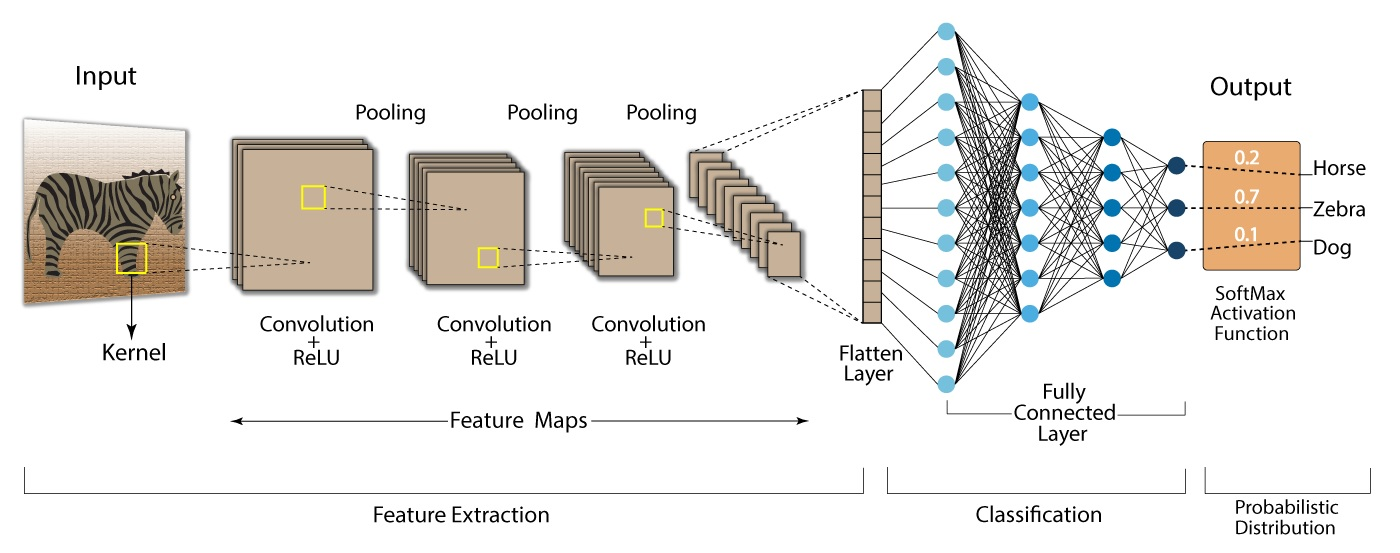
<p style='text-align: center;'>Image source: https://developersbreach.com/convolution-neural-network-deep-learning/</p>

A ConvNet model usually has two or three convolutional layers - each layer reduces the number of input features to the fully connected layers. The convolutional layers in CNN typically have the ReLu activation function. Additionally, we will set L2 regularization to prevent overfitting. This neural network will likely have a large number of parameters and might have lots of weights equal 0. Since we are dealing with a binary classification in which our outputs are in range {0, 1}, the activation function for the output layer must be a sigmoid/logistic function and <code>units</code> argument set as 1.

Our artificial neural network will contain three convolutional layers, three max pooling layers, one fully connected layer and one sigmoid output layer.

We will also implement the cross-entropy loss function (<code>binary_crossentropy</code>) for the compiling process. This function is the default one for binary classification tasks. The optimizer will be the Adam (a gradient descent based method).

In [6]:
# define CNN architecture and model
def develop_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
    from tensorflow.keras.regularizers import l2

    # define CNN model
    cnn_model = Sequential(
        [
            ### feature learning
            # 1st convolutional layer
            Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01),
                   input_shape=train_data.image_shape),
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # 2nd convolutional layer
            Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # 3rd convolutional layer
            Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            
            # fully connected classifier
            Flatten(),
            Dense(units=64, activation='relu'),
            Dropout(0.5),
            Dense(units=1, activation='sigmoid')
        ]
        )
    
    from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, SpecificityAtSensitivity
    from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
    
    # metrics for evaluation
    eval_metrics = [
        BinaryAccuracy(name='accuracy'),
        AUC(name='AUC'),
        TruePositives(name='TP'),
        FalsePositives(name='FP'),
        TrueNegatives(name='TN'),
        FalseNegatives(name='FN'), 
        Precision(name='precision'),
        Recall(name='recall'),
        SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')
    ]
    
    from tensorflow.keras.optimizers import Adam
    
    # define Adam optimizer and compile model
    adam_opt = Adam(learning_rate=0.001, beta_1=0.92, beta_2=0.999)
    cnn_model.compile(optimizer=adam_opt, loss='binary_crossentropy', metrics=eval_metrics)
    
    return cnn_model

# create a basic model instance
model = develop_model()

# display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                    

The learning operation will be set for 40 epochs. We will apply two callbacks in the function.

The first callback function - <code>EarlyStopping</code>, will monitor the training by <code>val_accuracy</code> metric. When the learning stops improving with the interval value 0.0001, the process will interrupt. The second callback overwrites the current save file for a defined frequency, in this case for each epoch. This is usefull since the training stage can be sometimes very long and we do not want to loose our progress and repeat the whole operation all over.

Since the callbacks are based on validation accuracy, the <code>mode</code> argument is made based on the maximization of the monitored quantity. For accuracy loss quantity it should be set as <code>max</code>. Analogously, monitoring by validation loss requires the mode defined as <code>min</code>.

In [7]:
# learning process
def fit_model():
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
    # 1st callback
    early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, verbose=1, patience=5, mode='max',
                                      restore_best_weights=True)
    
    # define path to save the model file
    fname = os.path.join(base_dir, 'cnn_model.h5')
    
    # 2nd callback
    checkpoint_cb = ModelCheckpoint(filepath=fname, monitor='val_accuracy', mode='max', save_best_only=True,
                                    verbose=0, save_weights_only=True, save_freq='epoch')
    
    global history_dict
    
    # fit model and coumpute coefficients
    history_dict = model.fit(train_data, epochs=40, validation_data=validation_data, shuffle=True,
                             verbose=1, callbacks=[early_stopping_cb, checkpoint_cb])
    
fit_model()

Epoch 1/40
131/131 [==============================] - 401s 3s/step - loss: 0.8813 - accuracy: 0.7690 - AUC: 0.7500 - TP: 3002.0000 - FP: 866.0000 - TN: 207.0000 - FN: 98.0000 - precision: 0.7761 - recall: 0.9684 - sensitivity: 0.5275 - val_loss: 0.4248 - val_accuracy: 0.8418 - val_AUC: 0.9176 - val_TP: 738.0000 - val_FP: 128.0000 - val_TN: 140.0000 - val_FN: 37.0000 - val_precision: 0.8522 - val_recall: 0.9523 - val_sensitivity: 0.8694
Epoch 2/40
131/131 [==============================] - 395s 3s/step - loss: 0.4328 - accuracy: 0.8222 - AUC: 0.8860 - TP: 2906.0000 - FP: 548.0000 - TN: 525.0000 - FN: 194.0000 - precision: 0.8413 - recall: 0.9374 - sensitivity: 0.8276 - val_loss: 0.3659 - val_accuracy: 0.8619 - val_AUC: 0.9318 - val_TP: 715.0000 - val_FP: 84.0000 - val_TN: 184.0000 - val_FN: 60.0000 - val_precision: 0.8949 - val_recall: 0.9226 - val_sensitivity: 0.9179
Epoch 3/40
131/131 [==============================] - 326s 2s/step - loss: 0.3670 - accuracy: 0.8680 - AUC: 0.9199 - TP:

Epoch 20/40
131/131 [==============================] - 155s 1s/step - loss: 0.2485 - accuracy: 0.9168 - AUC: 0.9613 - TP: 2916.0000 - FP: 163.0000 - TN: 910.0000 - FN: 184.0000 - precision: 0.9471 - recall: 0.9406 - sensitivity: 0.9627 - val_loss: 0.2108 - val_accuracy: 0.9243 - val_AUC: 0.9734 - val_TP: 726.0000 - val_FP: 30.0000 - val_TN: 238.0000 - val_FN: 49.0000 - val_precision: 0.9603 - val_recall: 0.9368 - val_sensitivity: 0.9813
Epoch 21/40
131/131 [==============================] - 149s 1s/step - loss: 0.2425 - accuracy: 0.9231 - AUC: 0.9626 - TP: 2926.0000 - FP: 147.0000 - TN: 926.0000 - FN: 174.0000 - precision: 0.9522 - recall: 0.9439 - sensitivity: 0.9655 - val_loss: 0.2572 - val_accuracy: 0.8984 - val_AUC: 0.9657 - val_TP: 689.0000 - val_FP: 20.0000 - val_TN: 248.0000 - val_FN: 86.0000 - val_precision: 0.9718 - val_recall: 0.8890 - val_sensitivity: 0.9664
Epoch 22/40
131/131 [==============================] - 149s 1s/step - loss: 0.2329 - accuracy: 0.9236 - AUC: 0.9651 - 

The classifier is ready for further use. We will save the computed metrics in a CSV file.

In [8]:
# save history as CSV file and load into dataframe
def save_history():
    import pandas as pd
    
    # save as CSV file
    pd.DataFrame.from_dict(history_dict.history).to_csv('history.csv', index=False)
    return pd.DataFrame.from_dict(history_dict.history)

history_csv = save_history()

Additionally, we will prepare functions to save and load the model.

In [9]:
# overwrite CNN model in local directory
def save_model():
    try:
        model.save(os.path.join(base_dir, 'cnn_model.h5'))
    except IOError:
        print('Model not saved')
    else:
        print('Model saved with success')
        
# load CNN model (optional use)
def load_model():
    from tensorflow.keras.models import load_model
    
    try:
        model = load_model(os.path.join(base_dir, 'cnn_model.h5'))
    except IOError:
        print('Model not loaded')
    else:
        print('Model loaded with success')
        return model

# run function
save_model()

Model saved with success


### 5. Diagnosing Model Behavior (Model Uncertainty)

At this stage, we will evaluate the performance and usefulness on the validation data and plot the learning curves. In general, these curves allow us to review the learning process. We can diagnose learning issues, such as an underfit or overfit model, and whether the training and testing datasets are suitably representative.

In [10]:
# perform evaluation on validation data
def evaluation_metrics():
    score_test = model.evaluate(test_data, verbose=1)

    print('\n======= Evaluation on Test Data =======')
    for name, value in zip(model.metrics_names, score_test):
        if name in ['TP', 'FP', 'TN', 'FN']:
            print('{}: {:.0f}'.format(name, value))
        elif name == 'AUC':
            print('{}: {:.4f}%'.format(name.upper(), value*100))
        else:
            print('{}: {:.4f}%'.format(name.capitalize(), value*100))
        
evaluation_metrics()

20/20 [==============================] - 11s 562ms/step - loss: 0.4433 - accuracy: 0.8606 - AUC: 0.9334 - TP: 379.0000 - FP: 76.0000 - TN: 158.0000 - FN: 11.0000 - precision: 0.8330 - recall: 0.9718 - sensitivity: 0.9060

======= Evaluation on Test Data =======
Loss: 44.3290%
Accuracy: 86.0577%
AUC: 93.3383%
TP: 379
FP: 76
TN: 158
FN: 11
Precision: 83.2967%
Recall: 97.1795%
Sensitivity: 90.5983%


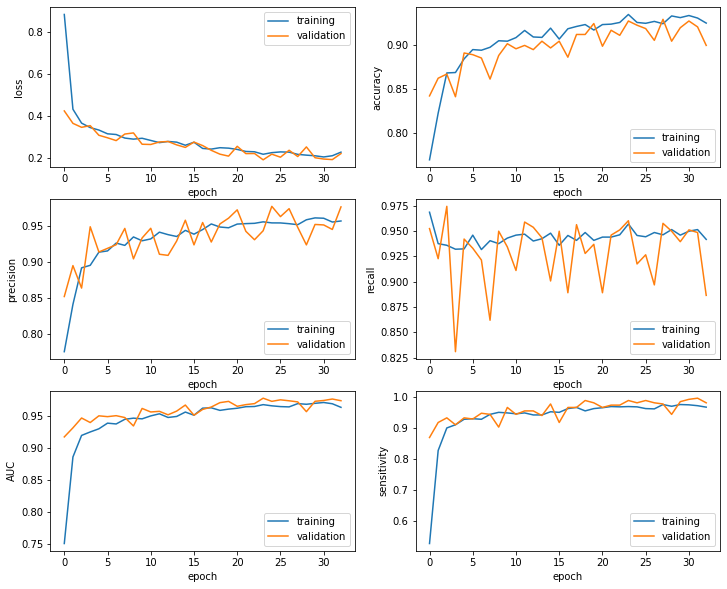

In [11]:
# plot learning curves
def diagnosis_plots():
    metric_list =  ['loss', 'accuracy', 'precision', 'recall', 'AUC', 'sensitivity']
    
    plt.figure(figsize=(12, 10))
    
    # loop through list of metrics
    for i, metric in enumerate(metric_list):   
        plt.subplot(3, 2, i+1)
        plt.plot(history_dict.epoch, history_dict.history[metric], label='training')
        plt.plot(history_dict.epoch, history_dict.history['val_'+ metric], label='validation')
        plt.legend(loc='best')
        plt.xlabel('epoch')
        plt.ylabel(metric)

diagnosis_plots()

Learning curves are a great diagnostic tool to determine bias and variance in a supervised machine learning algorithm. From these curves, we can clearly see that the learning ability gradually increases for each following epoch. 

The learning curves can also be used to diagnose properties of the dataset which in this case is relatively representative. This means the training dataset captured the statistical characteristics relative to the validation dataset drawn from the same domain. The ratio of samples between given datasets is correct.

We can present assigned class samples with a confusion matrix.

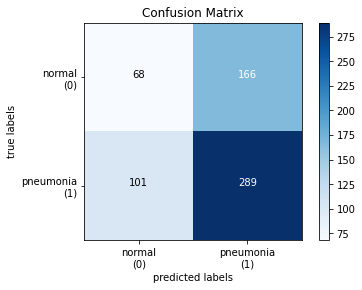

In [12]:
# plot confusion matrix for CNN classifier
def plot_confusion_matrix(normalize=False):
    from sklearn.metrics import confusion_matrix
    from numpy import arange
    
    # predictions on test data
    y_pred = model.predict(test_data)
    
    ######### plot confusion matrix
    if normalize:
        cm = confusion_matrix(y_true=test_data.classes, y_pred=(y_pred > 0.5).astype(int), normalize='all')
        plt.title('Normalized Confusion Matrix')
    else:
        cm = confusion_matrix(y_true=test_data.classes, y_pred=(y_pred > 0.5).astype(int), normalize=None)
        plt.title('Confusion Matrix')
        
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    
    # set ticks and axis labels
    class_labels = ['normal\n(0)', 'pneumonia\n(1)']
    plt.xticks(ticks=arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=arange(len(class_labels)), labels=class_labels)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    
    # set tile labels
    threshold = cm.max()/2
    for i in range(cm.shape[0]): 
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black')
    
    plt.show()    

plot_confusion_matrix() 

Finally, our last function will diagnose pneumonia based on an online X-ray. We will perform a single prediction for an image from [Wikipedia](https://en.wikipedia.org/wiki/Pneumonia#/media/File:Chest_radiograph_in_influensa_and_H_influenzae,_posteroanterior,_annotated.jpg). In this approach, the function will convert the picture into an array. For a binary classification the output of the prediction is a probability (a float) in range {0, 1}. Any threshold value higher than 0.5 indicates pneumonia. We will test the classifier on this picture in which pneumonia is obvious:

<img src=https://upload.wikimedia.org/wikipedia/commons/8/81/Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg width='300'>

In [13]:
# final predicting function
def predict_image(url_path: 'string'):
    import urllib.request
    from keras.preprocessing.image import load_img, img_to_array
    from numpy import expand_dims
    
    # retreive URL path to image
    img, _ = urllib.request.urlretrieve(url_path)
    
    # resize image
    test_xray = load_img(path=img, target_size=(150, 150))

    # convert PIL image into NumPy array
    test_xray = img_to_array(img=test_xray, data_format=None)
    test_xray = expand_dims(a=test_xray, axis=0)
    
    # diagnose pneumonia
    if model.predict(test_xray)[0][0] > 0.5:
        print('Pneumonia patient')
    else:
        print('Normal patient')

url = 'https://upload.wikimedia.org/wikipedia/commons/8/81/\
Chest_radiograph_in_influensa_and_H_influenzae%2C_posteroanterior%2C_annotated.jpg'

# make prediction
predict_image(url_path=url)

Pneumonia patient


The model recognized pneumonia correctly in this X-ray.

### 6. Conclusion

The topic of this notebook was to perform a binary classification problem on a digital image dataset to recognize pneumonia. To complete this task, we used deep learning and the <code>TensorFlow</code> library to build an image recognition model, a convolutional neural network. The algorithm was developed and performs correctly in terms of classifying patients radiology images. Deep learning techniques can definitely improve medical image computing. The concept of the neural network is to find patterns within visual data, in this case chest X-rays for normal and ill patients. Image classification could be helpful for physicians to analyze and track any illnesses based on chest radiology images.

**References:**<br>
1. A. Géron, 2019, *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition*
2. A.C. Müller, S. Guido, 2017, *Introduction to Machine Learning with Python: A Guide for Data Scientists*
3. https://www.cnvrg.io/cnn-tensorflow/ (Access: 22.01.2023)